In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import skimage.transform
import ast
import pandas as pd
import numpy as np
import math
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array as img_to_array
from tensorflow.keras.preprocessing.image import load_img as load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImageDataGenerator
import tensorflow.keras.preprocessing.image as tf_image
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as backend
import tensorflow.keras.regularizers as regularizers
import tensorflow.keras.models as models
import tensorflow.keras.metrics as metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import cv2

%matplotlib inline
np.random.seed(1)


In [2]:
#Allocate GPU Usage
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
session.run

<bound method BaseSession.run of <tensorflow.python.client.session.Session object at 0x0000018E984C1C50>>

In [53]:
# set constant variables
IM_SIZE = 224
NUM_EPOCHS = 30
BATCH_SIZE = 8
L2_WEIGHT_DECAY = 5e-4
BATCH_NORM_DECAY = 0.99
BATCH_NORM_EPSILON = 1e-5
ROOT_DIR = "train2014\\"
LBL_FILE = "train.txt"
DATA_FRAC=0.8

# Train and Test set Split

In [54]:
label = np.genfromtxt(LBL_FILE,dtype='str')[:,1]
image  = np.genfromtxt(LBL_FILE,dtype='str')[:,0]
print(label)
label_split = []
label_int = []
img_list = []
for i in range(0,label.shape[0]):
    label_split.append(label[i].split(','))
    label_int.append(list(map(int, label_split[i])))
    
#for i in range(0,image.shape[0]):
#    img_list.append(ROOT_DIR + image[i])   

label = np.array(label_int)
print(label[0])
print(label.shape)

['13,18' '19' '10' ... '19' '18,19' '16']
[13, 18]
(31925,)


In [55]:
one_hot = MultiLabelBinarizer()
label_one_hot = one_hot.fit_transform(label)

#Check
print(label[0])
print(label_one_hot[0])


[13, 18]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]


In [56]:

data_full = pd.DataFrame(np.genfromtxt('train.txt',dtype='str'))  
data_full[3] = label_one_hot.tolist()

In [57]:
X_train_df = data_full.sample(frac=DATA_FRAC,random_state=200)
X_train =  (ROOT_DIR + X_train_df[0]).tolist()
Y_train =  X_train_df[3].tolist()



In [58]:
X_test = (ROOT_DIR + data_full.loc[~data_full.index.isin(X_train_df.index)][0]).tolist()
Y_test = data_full.loc[~data_full.index.isin(X_train_df.index)][3].tolist()

In [61]:
len(X_train)

25540

In [59]:
len(Y_train)

25540

In [60]:
t_size = int(len(X_train)*90/100)

In [62]:
len(X_train[:t_size])

22986

display few sample images from the train dataset

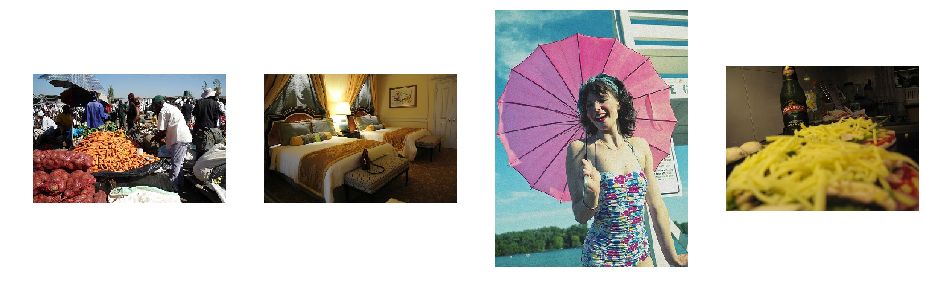

In [63]:
#mean of imagenet dataset in BGR
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)

current_dir = os.getcwd()

#Modify the image_dir to your local path to images
image_dir = os.path.join(ROOT_DIR)

%matplotlib inline

#get list of all images
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
#load all images
imgs = []
i=1
for f in img_files:
    if i<5:
        i+=1
        imgs.append(cv2.imread(f))
    
#plot images
fig = plt.figure(figsize=(20,10))
for i, img in enumerate(imgs):
    fig.add_subplot(1,5,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

Compare different image resolutions

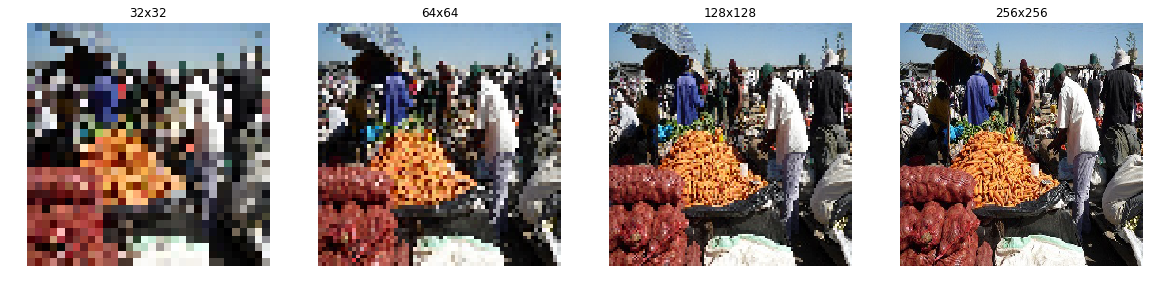

In [64]:
# data augmentation logic such as random rotations can be added here
#print( (img))

fig = plt.figure(figsize=(20,10))
for i in range(0, 4):
    res = [32,64,128,256]
    fig.add_subplot(1,4,i+1)
    img = img_to_array(load_img(ROOT_DIR+'0.jpg', target_size=(res[i], res[i])))/255.
    plt.imshow(img)
    plt.title(str(res[i])+'x'+str(res[i]))
    plt.axis('off')

In [65]:

def load_image(image_path, size):
    # data augmentation logic such as random rotations can be added here
    return img_to_array(load_img(image_path, target_size=(size, size)),dtype='np.float32') / 255.

class GeneratorSequence(tf.keras.utils.Sequence):
    """
    Custom Sequence object to train a model on out-of-memory datasets. 
    """
    
    def __init__(self, im_size, batch_size,x,y, mode='train'):
        """
        // add description
        
        """
        self.im_size = im_size
        self.batch_size = batch_size
        self.mode = mode

        # Take labels and a list of image locations in memory
        self.glabels = y 
        self.image_list = x 

        
    def __len__(self):
        return int(math.ceil(len(self.image_list) / float(self.batch_size)))

    def on_epoch_end(self):
        # Shuffles indexes after each epoch
        self.indexes = range(len(self.image_list))
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))

    def get_batch_labels(self, idx): 
        # Fetch a batch of labels
        return [self.glabels[idx * self.batch_size: (idx + 1) * self.batch_size]]

    def get_batch_features(self, idx):
        # Fetch a batch of images
        batch_images = self.image_list[idx * self.batch_size: (1 + idx) * self.batch_size]
        return np.array([load_image(im, self.im_size) for im in batch_images])

    def __getitem__(self, idx):
        batch_x = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

# ResNet50 Architecture and Impelemetation


In [18]:
def identity_block(input_tensor, kernel_size, filters):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = layers.Conv2D(filters1, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(input_tensor)

    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same', use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(x)

    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)

    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(x)

    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

In [19]:
def conv_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the second conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """

    filters1, filters2, filters3 = filters

    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = layers.Conv2D(filters1, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x = layers.Activation('relu')(x)


    x = layers.Conv2D(filters2, kernel_size, strides=strides, padding='same',
                      use_bias=False, kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(x)
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(x)
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)

    # Add CONV2D to match up input/output dimensions
    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, use_bias=False,
                             kernel_initializer='he_normal',
                             kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                            )(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis,
                                         momentum=BATCH_NORM_DECAY,
                                         epsilon=BATCH_NORM_EPSILON)(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [20]:
def resnet50(num_classes, input_shape):
    img_input = layers.Input(shape=input_shape)

    if backend.image_data_format() == 'channels_first':
        x = layers.Lambda(lambda x: backend.permute_dimensions(x, (0, 3, 1, 2)),
                          name='transpose')(img_input)
        bn_axis = 1
    else:  # channels_last
        x = img_input
        bn_axis = 3

    # Conv1 (7x7,64,stride=2)
    x = layers.ZeroPadding2D(padding=(3, 3))(x)

    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid', use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(x)
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)

    # 3x3 max pool,stride=2
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Conv2_x

    # 1×1, 64
    # 3×3, 64
    # 1×1, 256

    x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256])
    x = identity_block(x, 3, [64, 64, 256])

    # Conv3_x
    #
    # 1×1, 128
    # 3×3, 128
    # 1×1, 512

    x = conv_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])

    # Conv4_x
    # 1×1, 256
    # 3×3, 256
    # 1×1, 1024
    x = conv_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])

    # 1×1, 512
    # 3×3, 512
    # 1×1, 2048
    x = conv_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])

    # average pool, 1000-d fc, softmax
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(
        num_classes, activation='sigmoid',
        name='imgclass',
        kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY),
        bias_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
    )(x)

    # Create model.
    return models.Model(img_input, x, name='resnet50')

In [21]:
model=resnet50(20,(IM_SIZE, IM_SIZE, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
model.compile(loss = metrics.binary_crossentropy,
              #optimizer = tf.train.MomentumOptimizer(learning_rate= 1e-5 , momentum=0.9),
              optimizer= tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),#'adam',
              #metrics = [metrics.categorical_accuracy])             
              metrics=['top_k_categorical_accuracy',metrics.categorical_accuracy])

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation

# Train and Validate Model

In [31]:

def load_image(image_path, size):
    # data augmentation logic such as random rotations can be added here
    return img_to_array(load_img(image_path, target_size=(size, size))) / 255.

class GeneratorSequence(tf.keras.utils.Sequence):
    """
    Custom Sequence object to train a model on out-of-memory datasets. 
    """
    
    def __init__(self, im_size, batch_size,x,y, mode='train'):
        """
        // add description
        
        """
        self.im_size = im_size
        self.batch_size = batch_size
        self.mode = mode

        # Take labels and a list of image locations in memory
        self.glabels = y 
        self.image_list = x 

        
    def __len__(self):
        return int(math.ceil(len(self.image_list) / float(self.batch_size)))

    def on_epoch_end(self):
        # Shuffles indexes after each epoch
        self.indexes = range(len(self.image_list))
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))

    def get_batch_labels(self, idx): 
        # Fetch a batch of labels
        return [self.glabels[idx * self.batch_size: (idx + 1) * self.batch_size]]

    def get_batch_features(self, idx):
        # Fetch a batch of images
        batch_images = self.image_list[idx * self.batch_size: (1 + idx) * self.batch_size]
        return np.array([load_image(im, self.im_size) for im in batch_images])

    def __getitem__(self, idx):
        batch_x = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

In [29]:
%%time
# Sequence guarantees the ordering and guarantees the single use of every input per epoch when using
seq = GeneratorSequence(im_size=IM_SIZE, batch_size=BATCH_SIZE, x=X_train[:t_size],y=Y_train[:t_size] )
seq_val = GeneratorSequence(im_size=IM_SIZE, batch_size=BATCH_SIZE, x=X_train[t_size:],y=Y_train[t_size:] )

callbacks = [tf.keras.callbacks.ModelCheckpoint('./model.h5', verbose=1)]

H = model.fit_generator(generator=seq,
                    verbose=1, 
                    epochs=NUM_EPOCHS,
                    validation_data=seq_val,
                #    use_multiprocessing=True,
                #    workers=4,
                    callbacks=callbacks
                       )

model.save_weights("./resnet50_finetuned_tfOPT.h5")


Epoch 1/30
320/320 [==============================] - 15s 47ms/step - loss: 25.3268 - top_k_categorical_accuracy: 0.4488 - categorical_accuracy: 0.1382

Epoch 00001: saving model to ./model.h5
2874/2874 [==============================] - 464s 161ms/step - loss: 26.0591 - top_k_categorical_accuracy: 0.4344 - categorical_accuracy: 0.1149 - val_loss: 25.3268 - val_top_k_categorical_accuracy: 0.4488 - val_categorical_accuracy: 0.1382
Epoch 2/30
320/320 [==============================] - 14s 45ms/step - loss: 23.9341 - top_k_categorical_accuracy: 0.4703 - categorical_accuracy: 0.1296

Epoch 00002: saving model to ./model.h5
2874/2874 [==============================] - 456s 159ms/step - loss: 24.6182 - top_k_categorical_accuracy: 0.4966 - categorical_accuracy: 0.1350 - val_loss: 23.9341 - val_top_k_categorical_accuracy: 0.4703 - val_categorical_accuracy: 0.1296
Epoch 3/30
320/320 [==============================] - 14s 44ms/step - loss: 22.6135 - top_k_categorical_accuracy: 0.5434 - categoric

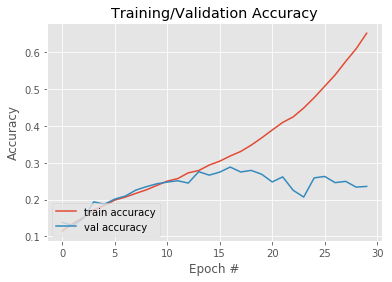

In [33]:
# plot the training loss and accuracy
N = NUM_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["categorical_accuracy"], label="train accuracy")
plt.plot(np.arange(0, N), H.history["val_categorical_accuracy"], label="val accuracy")
plt.title("Training/Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

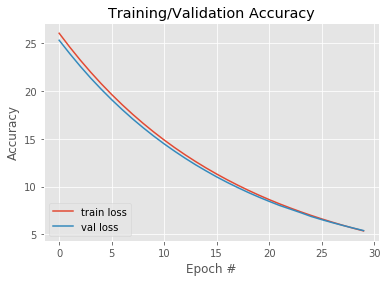

In [34]:
# plot the training loss and accuracy
N = NUM_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val loss")
plt.title("Training/Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# Predict Result

In [35]:
test_seq =  GeneratorSequence( 
                       im_size=IM_SIZE,
                       batch_size=BATCH_SIZE, x=X_test,y=Y_test, mode='test')
predictions = model.predict_generator(generator=test_seq, verbose=1)


799/799 [==============================] - 27s 34ms/step


In [47]:
def pred_accuracy(y_p,y_t):
    """Helper function to calculate accuracy"""  
    m = 0
    for i in range (len(y_t)):
        for j in range(len(y_p[i,:])):
            if  y_t[i,j]==1 and y_p[i,:].argmax(axis=0) == j:         
                m = m + 1       
    acc = m /(float(len(y_t)))*100
    print('Correct prediction: ' + str(m))
    print('Total prediction: ' + str(len(y_t)))
    return acc  

In [37]:
acc = pred_accuracy( predictions,np.array(Y_test) )
print('Accuracy: ' + str(acc)+'%')

Correct prediction: 1877
Total prediction: 6385
Accuracy: 29.397024275646043%


# Build Xception model with transfer learning

In [69]:
# set constant variables
IM_SIZE = 299
NUM_EPOCHS = 30
BATCH_SIZE = 8
L2_WEIGHT_DECAY = 5e-4
BATCH_NORM_DECAY = 0.99
BATCH_NORM_EPSILON = 1e-5
ROOT_DIR = "train2014\\"
LBL_FILE = "train.txt"
DATA_FRAC=0.8

In [41]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import layers

#Load the Xception model
Xception1 = Xception( weights='imagenet', include_top =False, input_shape=(299, 299, 3), pooling=None, classes=20)

# Freeze the layers except the last 1 layers
        
for layer in Xception1.layers[:-1]:
    layer.trainable = False

for layer in Xception1.layers:
    if (layer.name[-2] == "b" and layer.name[-1] == "n") or (layer.name == "batch_normalization_v1_20"):
        layer.trainable = True

Xception1.layers[-8].trainable = True
Xception1.layers[34].trainable = True
Xception1.layers[24].trainable = True
Xception1.layers[14].trainable = True

# Check the trainable status of the individual layers
for layer in Xception1.layers:
    print(layer, layer.trainable)
    
model_Xception_DownSize = models.Sequential()
 
# Add the Xception base model
model_Xception_DownSize.add(Xception1)
 
# Add new layers
model_Xception_DownSize.add(layers.Flatten())
model_Xception_DownSize.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.1)))
model_Xception_DownSize.add(layers.Dense(20, activation='sigmoid'))
 
# Show a summary of the model. Check the number of trainable parameters
model_Xception_DownSize.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001E862196DA0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E8621AD198> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x000001E8621ADC50> True
<tensorflow.python.keras.layers.core.Activation object at 0x000001E8621AD6A0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E8621E1240> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x000001E86222F8D0> True
<tensorflow.python.keras.layers.core.Activation object at 0x000001E862072160> False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x000001E6BD05B438> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x000001E6BD19BDA0> True
<tensorflow.python.keras.layers.core.Activation object at 0x000001E6BD19BDD8> False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x0

In [42]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.03, amsgrad=False)
sgd = optimizers.SGD(lr=0.045, decay=0.03, momentum=0.9, nesterov=True)

model_Xception_DownSize.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['categorical_accuracy'])

In [67]:
def load_image(image_path, size):
    # data augmentation logic such as random rotations can be added here
    return img_to_array(load_img(image_path, target_size=(size, size))) / 255.

class GeneratorSequence(tf.keras.utils.Sequence):
    """
    Custom Sequence object to train a model on out-of-memory datasets. 
    """
    
    def __init__(self, im_size, batch_size,x,y, mode='train'):
        """
        // add description
        
        """
        self.im_size = im_size
        self.batch_size = batch_size
        self.mode = mode

        # Take labels and a list of image locations in memory
        self.glabels = y 
        self.image_list = x 

        
    def __len__(self):
        return int(math.ceil(len(self.image_list) / float(self.batch_size)))

    def on_epoch_end(self):
        # Shuffles indexes after each epoch
        self.indexes = range(len(self.image_list))
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))

    def get_batch_labels(self, idx): 
        # Fetch a batch of labels
        return [self.glabels[idx * self.batch_size: (idx + 1) * self.batch_size]]

    def get_batch_features(self, idx):
        # Fetch a batch of images
        batch_images = self.image_list[idx * self.batch_size: (1 + idx) * self.batch_size]
        return np.array([load_image(im, self.im_size) for im in batch_images])

    def __getitem__(self, idx):
        batch_x = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

In [44]:
%%time
# Sequence guarantees the ordering and guarantees the single use of every input per epoch when using
seq = GeneratorSequence(im_size=IM_SIZE, batch_size=BATCH_SIZE, x=X_train[:t_size],y=Y_train[:t_size] )
seq_val = GeneratorSequence(im_size=IM_SIZE, batch_size=BATCH_SIZE, x=X_train[t_size:],y=Y_train[t_size:] )

callbacks = [tf.keras.callbacks.ModelCheckpoint('./XceptionDownSized.h5', verbose=1)]

H = model_Xception_DownSize.fit_generator(generator=seq,
                    verbose=1, 
                    epochs=NUM_EPOCHS,
                    validation_data=seq_val,
                #    use_multiprocessing=True,
                #    workers=4,
                    callbacks=callbacks)

Epoch 1/30
320/320 [==============================] - 24s 76ms/step - loss: 0.1742 - categorical_accuracy: 0.5818

Epoch 00001: saving model to ./XceptionDownSized.h5
2874/2874 [==============================] - 643s 224ms/step - loss: 0.3120 - categorical_accuracy: 0.4976 - val_loss: 0.1742 - val_categorical_accuracy: 0.5818
Epoch 2/30
320/320 [==============================] - 23s 72ms/step - loss: 0.1596 - categorical_accuracy: 0.5983

Epoch 00002: saving model to ./XceptionDownSized.h5
2874/2874 [==============================] - 631s 220ms/step - loss: 0.1692 - categorical_accuracy: 0.5698 - val_loss: 0.1596 - val_categorical_accuracy: 0.5983
Epoch 3/30
320/320 [==============================] - 23s 72ms/step - loss: 0.1543 - categorical_accuracy: 0.6085

Epoch 00003: saving model to ./XceptionDownSized.h5
2874/2874 [==============================] - 627s 218ms/step - loss: 0.1605 - categorical_accuracy: 0.5853 - val_loss: 0.1543 - val_categorical_accuracy: 0.6085
Epoch 4/30
320/3

In [45]:
test_seq =  GeneratorSequence( 
                       im_size=IM_SIZE,
                       batch_size=BATCH_SIZE, x=X_test,y=Y_test, mode='test')
predictions = model_Xception_DownSize.predict_generator(generator=test_seq, verbose=1)


799/799 [==============================] - 57s 71ms/step


In [48]:
acc = pred_accuracy(predictions,np.array(Y_test) )
print('Accuracy: ' + str(acc)+'%')

Correct prediction: 4589
Total prediction: 6385
Accuracy: 71.87157400156617%


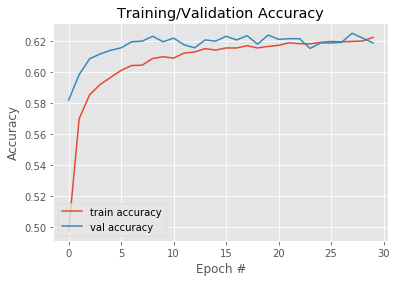

In [49]:
# plot the training loss and accuracy
N = NUM_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["categorical_accuracy"], label="train accuracy")
plt.plot(np.arange(0, N), H.history["val_categorical_accuracy"], label="val accuracy")
plt.title("Training/Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

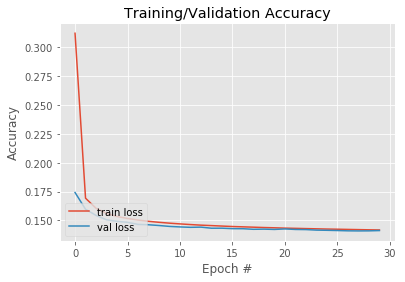

In [50]:
# plot the training loss and accuracy
N = 30

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val loss")
plt.title("Training/Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [55]:
model_Xception_DownSize.save('XceptionDownSized_Final.h5')

# Predict on Val Set

In [52]:
# Load model
from tensorflow.keras.models import load_model 
Xception_model = load_model('XceptionDownSized_Final.h5')

In [50]:
Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 25)                5120025   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                520       
Total params: 25,982,025
Trainable params: 5,175,073
Non-trainable params: 20,806,952
_________________________________________________________________


In [96]:
name = []

directory = os.fsencode("val2014")
temp = os.fsencode("\\")
temp1 = os.fsencode(".jpg") 
count = -1

for file in os.listdir(directory):
     count = count + 1
     temp2 = os.fsencode(str(count))
     name.append(directory + temp + temp2 + temp1)

In [97]:
test_seq =  GeneratorSequence( 
                       im_size=IM_SIZE,
                       batch_size=BATCH_SIZE, x=name,y=Y_test, mode='test')
predictions = Xception_model.predict_generator(generator=test_seq, verbose=1)


1940/1940 [==============================] - 134s 69ms/step


In [104]:
predictions_final = [] 
for i in range(0,len(predictions)):    
    predictions_final.append(np.argmax(predictions[i]))

In [113]:
img_name = []
directory = os.fsencode("val2014")
temp1 = ".jpg" 
count = -1

for file in os.listdir(directory):
     count = count + 1
     temp2 = str(count)
     img_name.append(temp2 + temp1)

In [114]:
names_output  = np.array(img_name)
predictions_output = np.array(predictions_final)
DAT =  np.column_stack((names_output, predictions_output))
np.savetxt('val.txt', DAT, delimiter=" ", fmt="%s") 